# Preamble

In [1]:
import os
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from intervaltree import Interval,IntervalTree

from time import time

import tensorflow as tf

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

%matplotlib inline

C:\Apps\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Constants

In [2]:
p = 16                  # pool size
stride = 8              # stride between pooled features
window = 16384          # size of the convolutional window
d = 2048                # receptive field
npools = (((window - d)/stride+1)/(p/2)-1)
k = 500                 # hidden nodes
m = 128                 # number of notes
fs = 44100              # samples/second
features = 0
labels = 1

restore_weights = True #False#True
folder = 'C:/Users/jq1n18/Downloads/thickstun2017learning-master/thickstun2017learning-masterconvnet/'

#musicnet = os.environ['MUSICNET']

### Load MusicNet

In [3]:
train_data = dict(np.load(open('C:\\Users\\jq1n18\\Downloads\\musicnet.npz','rb')))

In [4]:
# split our the test set
test_data = dict()
for id in (2303,2382,1819): # test set
    test_data[str(id)] = train_data.pop(str(id))
    
train_ids = train_data.keys()
test_ids = test_data.keys()
    
print len(train_data)
print len(test_data)

327
3


### Create the test set

In [5]:
# create the test set
samples = 7500
Xtest = np.zeros([3*samples,1,window,1])
Ytest = np.zeros([3*samples,m])
for i in range(len(test_ids)):
    for j in range(samples):
        index = int(fs)+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[samples*i + j] = test_data[test_ids[i]][features][index:index+window].reshape(1,window,1)
        Xtest[7500*i + j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[i]][labels][index+window/2]:
            Ytest[samples*i + j,label.data[1]] = 1

# Convnet

In [6]:
tf.reset_default_graph()
tf.set_random_seed(999)

x = tf.placeholder(tf.float32, shape=[None,1,window,1])
y_ = tf.placeholder(tf.float32, shape=[None, m])

scale = 10e-7
w = tf.Variable(scale*tf.random_normal([1,d,1,k],seed=999))
beta = tf.Variable(scale*tf.random_normal([npools*k,m],seed=999))

zx = tf.log(tf.constant(1.) + tf.nn.relu(tf.nn.conv2d(x,w,strides=[1,1,stride,1],padding='VALID')))
zxpool = tf.nn.avg_pool(zx,ksize=[1,1,p,1],strides=[1,1,p/2,1],padding='VALID')

y = tf.matmul(tf.squeeze(tf.reshape(zxpool,[tf.shape(x)[0],1,npools*k])),beta)
L = tf.reduce_mean(tf.nn.l2_loss(y-y_))

init = tf.global_variables_initializer()

In [7]:
folder= 'C://Users//jq1n18//Downloads//thickstun2017learning-master//thickstun2017learning-master//convet_small//'

if restore_weights:
    weights = np.load(open(folder + 'w.npy','rb'))
    coefficients = np.load(open(folder + 'beta.npy','rb'))
    average_precision = list(np.load(open(folder + 'ap.npy','rb')))
    square_error = list(np.load(open(folder + 'loss.npy','rb')))
    weights_top = list(np.load(open(folder + 'wtop.npy','rb')))
    weights_bottom = list(np.load(open(folder + 'wbot.npy','rb')))

    sess = tf.Session()
    sess.run(w.assign(weights))
    sess.run(beta.assign(coefficients))
    init_lr = .01/128
else:
    square_error = []
    weights_top = []
    weights_bottom = []
    average_precision = []
    sess = tf.Session()
    sess.run(init)
    init_lr = .01

In [8]:
lr = init_lr
train_step = tf.train.GradientDescentOptimizer(lr).minimize(L)
Xmb = np.empty([len(train_data),1,window,1])
start = time()
print 'iter\tsquare_loss\tweights_top\tweights_bottom\tavg_prec\ttime\t\teval_time'
for i in xrange(100000/10):
    if i % 100 == 0 and (i != 0 or len(square_error) == 0):
        eval_time = time()
        
        # split up test set
        se = 0.
        subdiv = 50
        subset = Xtest.shape[0]/subdiv
        for j in range(subdiv):
            se += sess.run(L, feed_dict={x: Xtest[subset*j:subset*(j+1)], y_: Ytest[subset*j:subset*(j+1)]})/subset
        square_error.append(se/50)
        #square_error.append(sess.run(L, feed_dict={x: Xtest[0:3000], y_: Ytest[0:3000]})/Xtest.shape[0])
        weights_top.append(np.mean(np.linalg.norm(beta.eval(session=sess),axis=0)))
        weights_bottom.append(np.mean(np.linalg.norm(w.eval(session=sess),axis=1)))
        
        Yhattestbase = np.empty((Xtest.shape[0],m))
        for j in range(subdiv):
            Yhattestbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xtest[subset*j:subset*(j+1)]})
        #Yhattestbase = sess.run(y,feed_dict={x: Xtest})
        yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
        yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])
        average_precision.append(average_precision_score(yflat, yhatflat))
        
        end = time()
        print i,'\t', square_error[-1],\
                '\t', weights_top[-1],\
                '\t', weights_bottom[-1],\
                '\t', average_precision[-1],\
                '\t',end-start,\
                '\t',end-eval_time
        start = time()
    
    Ymb = np.zeros([len(train_data),m])
    for j in range(len(train_data)):
        s = np.random.randint(window/2,len(train_data[train_ids[j]][features])-window/2)
        Xmb[j] = train_data[train_ids[j]][features][s-window/2:s+window/2].reshape(1,window,1)
        Xmb[j] /= np.linalg.norm(Xmb[j]) + 10e-6
        for label in train_data[train_ids[j]][labels][s]:
            Ymb[j,label.data[1]] = 1

    sess.run(train_step, feed_dict={x: Xmb, y_: Ymb})

iter	square_loss	weights_top	weights_bottom	avg_prec	time		eval_time
100 	0.8063212483723957 	0.75828624 	0.20093666 	0.5242132794368919 	4190.70300007 	1619.87100005
200 	0.8042947645399307 	0.7586012 	0.20168492 	0.5257863444549029 	4240.42700005 	1651.40700006
300 	0.8034075697157117 	0.7587925 	0.20208524 	0.526418782254878 	4281.13599992 	1648.49299979
400 	0.8030739691840278 	0.759055 	0.20262936 	0.5264769410019465 	4251.03800011 	1649.89700007
500 	0.8026300882975264 	0.75926566 	0.20306446 	0.5267696265152805 	4296.8670001 	1688.41600013
600 	0.8018819417317709 	0.7594665 	0.20347714 	0.5273806935472338 	4455.25399995 	1673.61300015


KeyboardInterrupt: 

In [9]:
burnin=1
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.plot(average_precision[burnin:],color='g')
ax2.set_title('square loss')
ax2.plot(square_error[burnin:],color='g')
ax3.set_title('weights top')
ax3.plot(weights_top[burnin:],color='g')
ax4.set_title('weights bottom')
ax4.plot(weights_bottom[burnin:],color='g')

Error in callback <function post_execute at 0x0000000007AA5518> (for post_execute):


LookupError: unknown encoding: mac_roman

LookupError: unknown encoding: mac_roman

<Figure size 864x720 with 4 Axes>

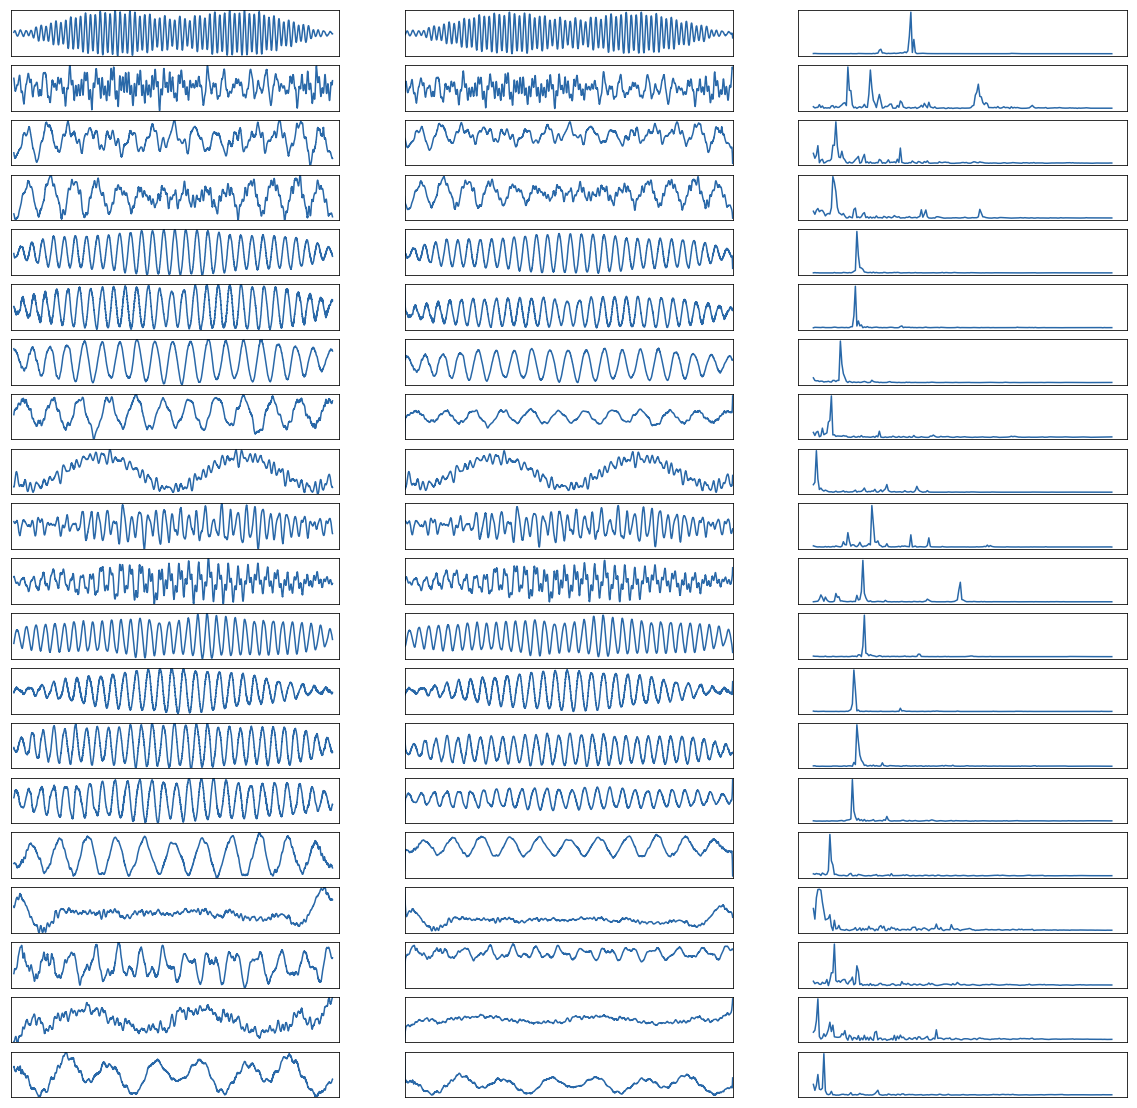

In [10]:
offset = 20
f, ax = plt.subplots(20,3, sharey=False)
f.set_figheight(20)
f.set_figwidth(20)
weights = w.eval(session=sess)[0,:,0,:]
for i in range(20):
    ax[i,0].plot(weights[10:-10,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,0].set_xlim([-20,d+20])
    ax[i,0].set_ylim([np.min(weights[10:-10,i+offset]),np.max(weights[10:-10,i+offset])])
    ax[i,0].set_xticklabels([])
    ax[i,0].set_yticklabels([])
    ax[i,1].plot(weights[d/2-1024:d/2+1024,i+offset], color=(41/255.,104/255.,168/255.))
    ax[i,1].set_xticklabels([])
    ax[i,1].set_yticklabels([])
    ax[i,1].set_xlim([0,2048])
    ax[i,2].plot(np.abs(fft(weights[d/2-1024:d/2+1024,i+offset]))[0:200], color=(41/255.,104/255.,168/255.))
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])
    
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

In [29]:
folder= 'C://Users//jq1n18//Downloads//thickstun2017learning-master//thickstun2017learning-master//convet_small//'

weights = w.eval(session=sess)
coefficients = beta.eval(session=sess)

np.save(open(folder + 'w.npy','wb'),weights)
np.save(open(folder + 'beta.npy','wb'),coefficients)
np.save(open(folder + 'ap.npy','wb'),average_precision)
np.save(open(folder + 'loss.npy','wb'),square_error)
np.save(open(folder + 'wtop.npy','wb'),weights_top)
np.save(open(folder + 'wbot.npy','wb'),weights_bottom)

# Linear classifier

In [27]:
n = 1000              # training data points per recording

# sufficient statistics for least squares
XTX = np.zeros((npools*k,npools*k))
XTY = np.zeros((npools*k,m))

# Warning: this could take some time
Xs = np.empty((n,npools*k))
for recording in train_data:
    print recording, ',',
    X,Y = train_data[recording]
    s = np.random.randint(window/2,len(X)-window/2,n)
    Ys = np.zeros((n,m))
    for i in range(n):
        Xnorm = X[s[i]-window/2:s[i]+window/2]
        Xnorm /= np.linalg.norm(Xnorm) + 10e-6
        
        Xs[i] = sess.run(zxpool,feed_dict={x: Xnorm.reshape(1,1,window,1)}).reshape(npools*k)
        for label in Y[s[i]]:
            Ys[i,label.data[1]] = 1
    XTX += (1./n)*np.dot(Xs.T,Xs)
    XTY += (1./n)*np.dot(Xs.T,Ys)
XTX /= float(len(train_data))
XTY /= float(len(train_data))

MemoryError: 

In [ ]:
grid = [2**i for i in range(-25,-10)]
ap_ls = []
for r in grid:
    print r,', ',
    betals = np.linalg.solve(XTX + r*np.eye(XTX.shape[0]),XTY)
    
    Yhat = np.dot(sess.run(zx,feed_dict={x: Xtest}).reshape(len(Xtest),(2*p+1)*k),betals)
    yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
    yhatflat = Yhat.reshape(Yhat.shape[0]*Yhat.shape[1])
    ap_ls.append(average_precision_score(yflat, yhatflat))
    
fig = plt.figure()
plt.plot(range(-25,-10),ap_ls,color=(41/255.,104/255.,168/255.),linewidth=3)
fig.axes[0].set_xlabel('regularizer (order of magnitude)')
fig.axes[0].set_ylabel('average precision')

# MIREX evaluation

In [28]:
def estimate(X,subdiv=50):
    subset = X.shape[0]/subdiv
    Yhatbase = np.empty((X.shape[0],m))
    for j in range(subdiv):
        Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: X[subset*j:subset*(j+1)]})
        
    return Yhatbase

In [29]:
import mir_eval

In [30]:
Xvalidation = np.zeros([50*len(train_data),window])
Yvalidation = np.zeros([50*len(train_data),m])
for i in range(len(train_data)):
    # 50 random samples from each recording
    s = np.random.randint(window/2,len(train_data[train_ids[i]][features])-window/2,size=100)
    for j in range(50):
        Xvalidation[50*i+j] = train_data[train_ids[i]][features][s[j]-window/2:s[j]+window/2]
        Xvalidation[50*i+j] /= np.linalg.norm(Xvalidation[50*i+j]) + 10e-6
        # label stuff that's on in the center of the window
        for label in train_data[train_ids[i]][labels][s[j]]:
            Yvalidation[50*i+j,label.data[1]] = 1
            
Xvalidation = Xvalidation.reshape(Xvalidation.shape[0],1,Xvalidation.shape[1],1)

In [31]:
#Yhatbase = np.dot(sess.run(zx,feed_dict={x: Xvalidation}).reshape(len(Xvalidation),(2*p+1)*k),betals)
subdiv = 50
subset = Xvalidation.shape[0]/subdiv
Yhatbase = np.empty((Xvalidation.shape[0],m))
for j in range(subdiv):
    Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xvalidation[subset*j:subset*(j+1)]})

. . . . . 0.224


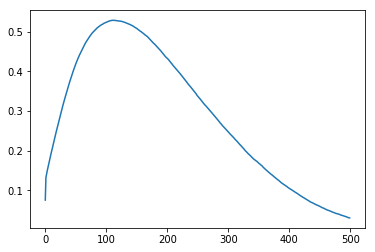

In [32]:
# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

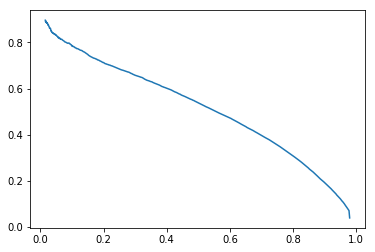

In [33]:
plt.plot(R,P)

In [34]:
subset = Xtest.shape[0]/subdiv
Yhattestbase = np.empty((Xtest.shape[0],m))
for j in range(subdiv):
    Yhattestbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xtest[subset*j:subset*(j+1)]})
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.5243185673148988
0.6072179077204203
0.5627315255815921


0.58778577687111


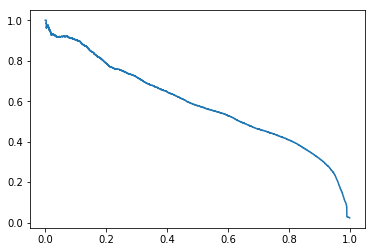

In [35]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

In [36]:
#Yhatbase = np.dot(sess.run(zx,feed_dict={x: Xtest}).reshape(len(Xtest),(2*p+1)*k),betals)
subdiv = 50
subset = Xtest.shape[0]/subdiv
Yhatbase = np.empty((Xtest.shape[0],m))
for j in range(subdiv):
    Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xtest[subset*j:subset*(j+1)]})

Yhat = Yhatbase>c
Yhatlist = []
Ytestlist = []
for i in range(len(Yhat)):
    fhat = []
    ftest = []
    for note in range(128):
        if Yhat[i][note] == 1:
            fhat.append(440.*2**((note - 69.)/12.))
        if Ytest[i][note] == 1:
            ftest.append(440.*2**((note - 69.)/12.))
    Yhatlist.append(np.array(fhat))
    Ytestlist.append(np.array(ftest))

In [37]:
P,R,Acc,Esub,Emiss,Efa,Etot,cP,cR,cAcc,cEsub,cEmiss,cEfa,cEtot = \
mir_eval.multipitch.metrics(np.arange(len(Ytestlist))/100.,Ytestlist,np.arange(len(Yhatlist))/100.,Yhatlist)

print P
print R
print Acc
print Etot
print Esub
print Emiss
print Efa

print '-----'

print cP
print cR
print cAcc
print cEtot
print cEsub
print cEmiss
print cEfa

0.524318567315
0.60721790772
0.39152846917434975
0.7474645957058017
0.19620831429876656
0.19657377798081316
0.35468250342622204
-----
0.572442901661
0.662951119233
0.4433988206178007
0.6917313841936957
0.1404751027866606
0.19657377798081316
0.35468250342622204


# Precision/Recall

In [38]:
fs = 44100.
m = 128

composition = 2

# create the test set (INDIVIDUAL COMPOSITIONS)
samples = 7500
Xtest = np.zeros([samples,1,window,1])
Ytest = np.zeros([samples,m])
for i in range(1):
    for j in range(samples):
        index = int(fs)+j*512 # start from one second to give us some wiggle room for larger segments
        Xtest[samples*i + j] = test_data[test_ids[composition]][features][index:index+window].reshape(1,window,1)
        Xtest[7500*i + j] /= np.linalg.norm(Xtest[7500*i + j]) + 10e-6
        
        # label stuff that's on in the center of the window
        for label in test_data[test_ids[i+composition]][labels][index+window/2]:
            Ytest[samples*i + j,label.data[1]] = 1

In [39]:
print test_ids[composition]

1819


In [40]:
subset = Xvalidation.shape[0]/subdiv
Yhatbase = np.empty((Xvalidation.shape[0],m))
for j in range(subdiv):
    Yhatbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xvalidation[subset*j:subset*(j+1)]})

. . . . . 0.224


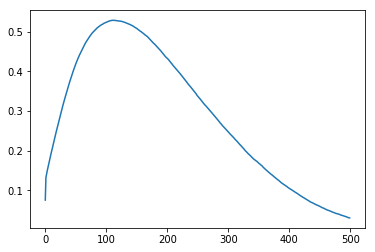

In [41]:
# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalidation)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalidation)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

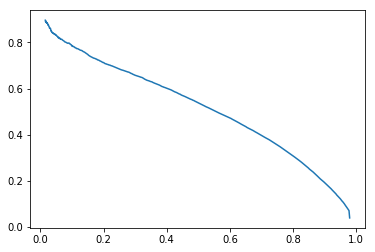

In [42]:
plt.plot(R,P)

In [43]:
subset = Xtest.shape[0]/subdiv
Yhattestbase = np.empty((Xtest.shape[0],m))
for j in range(subdiv):
    Yhattestbase[subset*j:subset*(j+1)] = sess.run(y,feed_dict={x: Xtest[subset*j:subset*(j+1)]})
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.5243185673148988
0.6072179077204203
0.5627315255815921


0.58778577687111


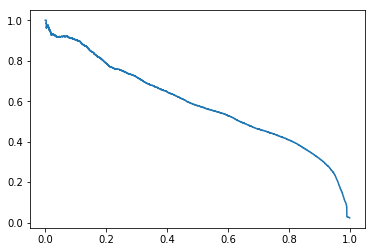

In [44]:
yflat = Ytest.reshape(Ytest.shape[0]*Ytest.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision, recall, _ = precision_recall_curve(yflat, yhatflat)
ap = average_precision_score(yflat, yhatflat)
plt.plot(recall,precision)
print ap

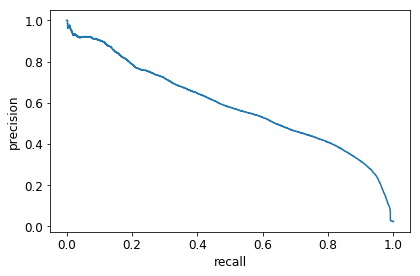

In [45]:
plt.rcParams.update({'font.size': 12})

fig = plt.figure()
plt.plot(recall,precision)
fig.axes[0].set_xlabel('recall')
fig.axes[0].set_ylabel('precision')

plt.tight_layout()
plt.savefig('convnet_pr.eps',format='eps', dpi=1000)

# Breakdown of test

In [46]:
Yvalid1 = Yvalidation[np.sum(Yvalidation,axis=1)==1]
Yvalid2 = Yvalidation[np.sum(Yvalidation,axis=1)==2]
Yvalid3 = Yvalidation[np.sum(Yvalidation,axis=1)==3]
Yvalid4 = Yvalidation[np.sum(Yvalidation,axis=1)==4]
Yvalid5 = Yvalidation[np.sum(Yvalidation,axis=1)==5]
Yvalid6 = Yvalidation[np.sum(Yvalidation,axis=1)==6]
Ytest1 = Ytest[np.sum(Ytest,axis=1)==1]
Ytest2 = Ytest[np.sum(Ytest,axis=1)==2]
Ytest3 = Ytest[np.sum(Ytest,axis=1)==3]
Ytest4 = Ytest[np.sum(Ytest,axis=1)==4]
Ytest5 = Ytest[np.sum(Ytest,axis=1)==5]
Ytest6 = Ytest[np.sum(Ytest,axis=1)==6]

In [47]:
Yhatbase = estimate(Xvalidation[np.sum(Yvalidation,axis=1)==1])
Yhattestbase = estimate(Xtest[np.sum(Ytest,axis=1)==1])

. . . . . 0.408


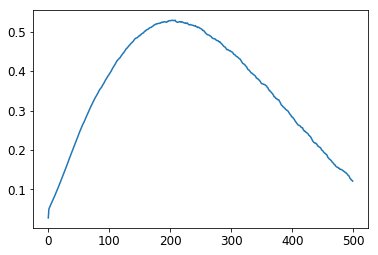

In [48]:
# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid1)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid1)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [49]:
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest1)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest1))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.7230962869729389
0.8224767358625626
0.769591426657736


0.8138929022524555


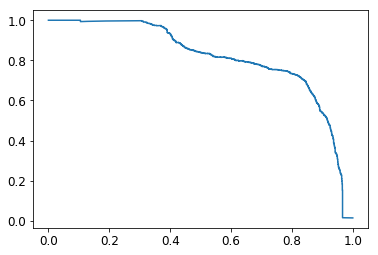

In [50]:
yflat = Ytest1.reshape(Ytest1.shape[0]*Ytest1.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision1, recall1, _ = precision_recall_curve(yflat, yhatflat)
average_precision1 = average_precision_score(yflat, yhatflat)
plt.plot(recall1,precision1)
print average_precision1

In [51]:
Yhatbase = estimate(Xvalidation[np.sum(Yvalidation,axis=1)==4])
Yhattestbase = estimate(Xtest[np.sum(Ytest,axis=1)==4])

. . . . . 0.192


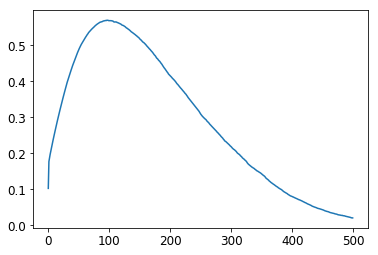

In [52]:
# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid4)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid4)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

plt.plot(F)
i = np.argmax(F)
c = i/float(density)
print c

In [53]:
Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest4)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest4))
F = 2*(P*R)/(P+R)
print P
print R
print F

0.5637065637065637
0.722486144101346
0.6332957404354992


0.6535213940673312


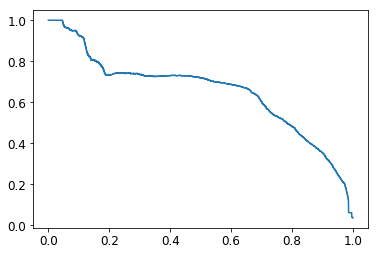

In [54]:
yflat = Ytest4.reshape(Ytest4.shape[0]*Ytest4.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision4, recall4, _ = precision_recall_curve(yflat, yhatflat)
average_precision4 = average_precision_score(yflat, yhatflat)
plt.plot(recall4,precision4)
print average_precision4

In [ ]:
Yhatbase = sess.run(y,feed_dict={x: Xvalidation[np.sum(Yvalidation,axis=1)==2]})
Yhattestbase = sess.run(y,feed_dict={x: Xtest[np.sum(Ytest,axis=1)==2]})

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid2)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid2)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest2)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest2))
F = 2*(P*R)/(P+R)

yflat = Ytest2.reshape(Ytest2.shape[0]*Ytest2.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision2, recall2, _ = precision_recall_curve(yflat, yhatflat)
average_precision2 = average_precision_score(yflat, yhatflat)
plt.plot(recall2,precision2)
print average_precision2

In [ ]:
Yhatbase = estimate(Xvalidation[np.sum(Yvalidation,axis=1)==3])
Yhattestbase = estimate(Xtest[np.sum(Ytest,axis=1)==3])

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid3)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid3)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest3)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest3))
F = 2*(P*R)/(P+R)

yflat = Ytest3.reshape(Ytest3.shape[0]*Ytest3.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision3, recall3, _ = precision_recall_curve(yflat, yhatflat)
average_precision3 = average_precision_score(yflat, yhatflat)
plt.plot(recall3,precision3)
print average_precision3

In [ ]:
Yhatbase = estimate(Xvalidation[np.sum(Yvalidation,axis=1)==5])
Yhattestbase = estimate(Xtest[np.sum(Ytest,axis=1)==5])

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid5)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid5)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest5)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest5))
F = 2*(P*R)/(P+R)

yflat = Ytest5.reshape(Ytest5.shape[0]*Ytest5.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision5, recall5, _ = precision_recall_curve(yflat, yhatflat)
average_precision5 = average_precision_score(yflat, yhatflat)
plt.plot(recall5,precision5)
print average_precision5

In [ ]:
Yhatbase = estimate(Xvalidation[np.sum(Yvalidation,axis=1)==6])
Yhattestbase = estimate(Xtest[np.sum(Ytest,axis=1)==6])

# single threshold
density = 500
P = np.empty(density)
R = np.empty(density)
F = np.empty(density)
for i in np.arange(density):
    if i % 100 == 0: print '.',
    c = i/float(density)
    Yhat = Yhatbase>c
    true_positives = np.sum(Yhat*Yvalid6)
    P[i] = true_positives/np.sum(Yhat)
    R[i] = true_positives/np.sum(Yvalid6)
    F[i] = 2*(P[i]*R[i])/(P[i]+R[i])

Yhat = Yhattestbase>c
true_positives = np.sum(Yhat*Ytest6)
P = true_positives/(np.sum(Yhat))
R = true_positives/(np.sum(Ytest6))
F = 2*(P*R)/(P+R)

yflat = Ytest6.reshape(Ytest6.shape[0]*Ytest6.shape[1])
yhatflat = Yhattestbase.reshape(Yhattestbase.shape[0]*Yhattestbase.shape[1])

precision6, recall6, _ = precision_recall_curve(yflat, yhatflat)
average_precision6 = average_precision_score(yflat, yhatflat)
plt.plot(recall6,precision6)
print average_precision6

In [ ]:
plt.rcParams.update({'font.size': 16})

thickness = 3

fig = plt.figure()
total, = plt.plot(recall,precision,color=(41/255.,104/255.,168/255.),linewidth=thickness)
one, = plt.plot(recall1,precision1,color=(70/255.,179/255.,76/255.),linewidth=thickness)
#two, = plt.plot(recall2,precision2,color='c')
three, = plt.plot(recall3,precision3,color=(180/255.,50/255.,47/255.),linewidth=thickness)
#four, = plt.plot(recall4,precision4,color='m')
#five, = plt.plot(recall5,precision5,color='y')
#six, = plt.plot(recall6,precision6,color='k')
ax = fig.axes[0]
leg = ax.legend([total,one,three],['overall','one-note','three-notes'],\
          loc='upper right',ncol=1,prop={'size':11})
for legobj in leg.legendHandles:
    legobj.set_linewidth(7.0)
ax.set_xlabel('recall')
ax.set_ylabel('precision')
plt.tight_layout()
plt.savefig('prcurve.eps',format='eps', dpi=1000)